<a href="https://colab.research.google.com/github/Ayon150/AI/blob/main/Homework_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image shape: (512, 512)
Huffman: encoded bits (meaningful) = 1903718, approx compression ratio = 1.10:1
DCT (Q=50): approx nonzero coeffs = 31553/262144, approx ratio = 8.31:1
DWT (haar, level=2): threshold=11.1090, nonzero coeffs=54213/262144, approx ratio = 4.84:1
PSNRs (dB):
  Huffman lossless roundtrip PSNR: inf
  DCT recon PSNR: 32.59937288315491
  DWT recon PSNR: 32.68603871270016


/usr/local/lib/python3.12/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


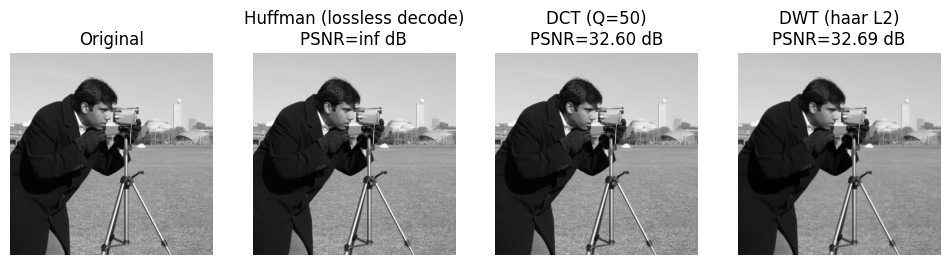


Summary:
  Image: (512, 512)
  Huffman: Encoded bits = 1903718, Ratio ≈ 1.10:1, PSNR = inf dB (lossless roundtrip)
  DCT: Ratio ≈ 8.31:1, Nonzero coeffs = 31553/262144, PSNR = 32.60 dB
  DWT: Ratio ≈ 4.84:1, Nonzero coeffs = 54213/262144, PSNR = 32.69 dB, thr=11.1090


In [1]:
# Colab-ready: Image compression demo implementing Huffman, DCT (JPEG-like), and DWT (wavelet) methods.
# Copy this whole cell into Google Colab and run.
# If you want to use your own image, upload it via the Colab file selector and set `input_path`.

# --- Install requirements (uncomment if running in a clean Colab environment) ---
# !pip install pywavelets scikit-image imageio==2.9.0

import io
import sys
import math
import heapq
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, io as skio, img_as_ubyte
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.util import view_as_blocks
from scipy.fftpack import dct, idct

# Try to import pywt; if not present, prompt user (in Colab uncomment pip above)
try:
    import pywt
except Exception as e:
    raise ImportError("pywt (PyWavelets) is required. In Colab run: !pip install pywavelets") from e

# -------------------------
# Utility helpers
# -------------------------
def rgb2gray_uint8(img):
    """Return grayscale uint8 image."""
    if img.ndim == 3:
        img = color.rgb2gray(img)
    img = img_as_ubyte(img)  # converts to uint8 (0-255)
    return img

def show_images(orig, recon_dict, figsize=(12,6)):
    """Display original + reconstructed images in recon_dict: {label: image}"""
    n = 1 + len(recon_dict)
    plt.figure(figsize=figsize)
    plt.subplot(1, n, 1)
    plt.title("Original")
    plt.imshow(orig, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    i = 2
    for k,v in recon_dict.items():
        plt.subplot(1, n, i)
        plt.title(k + f"\nPSNR={psnr(orig, v):.2f} dB")
        plt.imshow(v, cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
        i += 1
    plt.show()

# -------------------------
# 1) Huffman coding (grayscale)
# -------------------------
class HuffmanNode:
    def __init__(self, value=None, freq=0, left=None, right=None):
        self.value = value
        self.freq = freq
        self.left = left
        self.right = right
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freq_map):
    heap = [HuffmanNode(v, f) for v,f in freq_map.items()]
    heapq.heapify(heap)
    if len(heap) == 1:
        # Special-case single symbol
        node = heapq.heappop(heap)
        return HuffmanNode(None, node.freq, left=node)
    while len(heap) > 1:
        a = heapq.heappop(heap)
        b = heapq.heappop(heap)
        merged = HuffmanNode(None, a.freq + b.freq, left=a, right=b)
        heapq.heappush(heap, merged)
    return heap[0]

def build_codes(node, prefix="", codebook=None):
    if codebook is None:
        codebook = {}
    if node is None:
        return codebook
    if node.value is not None:  # leaf
        codebook[node.value] = prefix if prefix != "" else "0"
    else:
        build_codes(node.left, prefix + "0", codebook)
        build_codes(node.right, prefix + "1", codebook)
    return codebook

def huffman_encode(img):
    # img: uint8 2D
    flat = img.flatten()
    # frequency map
    unique, counts = np.unique(flat, return_counts=True)
    freq_map = {int(u): int(c) for u,c in zip(unique, counts)}
    root = build_huffman_tree(freq_map)
    codebook = build_codes(root)
    # encode
    bitstr = "".join(codebook[int(b)] for b in flat)
    # pack to bytes
    pad_len = (8 - len(bitstr) % 8) % 8
    bitstr_padded = bitstr + "0"*pad_len
    b = bytearray()
    for i in range(0, len(bitstr_padded), 8):
        byte = bitstr_padded[i:i+8]
        b.append(int(byte, 2))
    metadata = {
        "codebook": codebook,
        "pad_len": pad_len,
        "shape": img.shape
    }
    return bytes(b), metadata, len(bitstr)  # return raw bytes + metadata + number of meaningful bits

def huffman_decode(encoded_bytes, metadata):
    codebook = metadata["codebook"]
    pad_len = metadata["pad_len"]
    shape = metadata["shape"]
    # invert codebook
    inv = {v:k for k,v in codebook.items()}
    # bytes to bitstring
    bitstr = "".join(f"{byte:08b}" for byte in encoded_bytes)
    if pad_len:
        bitstr = bitstr[:-pad_len]
    # decode by prefix matching
    out = []
    cur = ""
    for bit in bitstr:
        cur += bit
        if cur in inv:
            out.append(inv[cur])
            cur = ""
    arr = np.array(out, dtype=np.uint8).reshape(shape)
    return arr

# -------------------------
# 2) DCT-based compression (8x8 block DCT + quantization)
# -------------------------
# Standard JPEG luminance quantization table (example)
JPEG_Q50 = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,58,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]
])

def quality_scale_matrix(Q=50):
    if Q < 50:
        S = 5000 / Q
    else:
        S = 200 - 2*Q
    mat = np.floor((JPEG_Q50 * S + 50) / 100)
    mat[mat==0] = 1
    return mat.astype(np.int32)

def block_dct_2d(block):
    # apply DCT-II along rows then columns (normalized)
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def block_idct_2d(coeff):
    return idct(idct(coeff.T, norm='ortho').T, norm='ortho')

def dct_compress(img, block_size=8, quality=50):
    # img: uint8 2D image
    h,w = img.shape
    # pad to multiple of block_size
    ph = (block_size - (h % block_size)) % block_size
    pw = (block_size - (w % block_size)) % block_size
    padded = np.pad(img, ((0,ph),(0,pw)), mode='constant', constant_values=0).astype(np.float32) - 128.0
    # process blocks
    mat = quality_scale_matrix(quality)
    recon = np.zeros_like(padded)
    nonzero = 0
    total_coeffs = 0
    for i in range(0, padded.shape[0], block_size):
        for j in range(0, padded.shape[1], block_size):
            block = padded[i:i+block_size, j:j+block_size]
            C = block_dct_2d(block)
            Q = np.round(C / mat).astype(np.int32)
            nonzero += np.count_nonzero(Q)
            total_coeffs += Q.size
            Cq = Q * mat
            rec_block = block_idct_2d(Cq)
            recon[i:i+block_size, j:j+block_size] = rec_block
    recon = (recon + 128.0)[:h, :w]
    recon_clipped = np.clip(np.round(recon), 0, 255).astype(np.uint8)
    comp_ratio = (h*w*8) / ( (nonzero) * 8 if nonzero>0 else 1 )  # approximation in bits (1 byte per nonzero coefficient is naive)
    return recon_clipped, comp_ratio, nonzero, total_coeffs

# -------------------------
# 3) DWT-based compression (wavelet coeff thresholding)
# -------------------------
def dwt_compress(img, wavelet='haar', level=2, threshold_factor=1.0):
    # img: uint8 2D
    arr = img.astype(np.float32)
    coeffs = pywt.wavedec2(arr, wavelet=wavelet, level=level)
    # build array of detail coefficients' absolute values to compute threshold
    # Flatten all detail coefficients
    all_coeffs = []
    for i, c in enumerate(coeffs):
        if i == 0:
            all_coeffs.append(c.ravel())
        else:
            for comp in c:
                all_coeffs.append(comp.ravel())
    all_coeffs = np.concatenate(all_coeffs)
    sigma = np.median(np.abs(all_coeffs)) / 0.6745  # robust estimate
    # universal threshold
    thr = threshold_factor * sigma * math.sqrt(2*math.log(arr.size))
    # soft thresholding
    coeffs_thresh = []
    nonzero = 0
    total = 0
    for i, c in enumerate(coeffs):
        if i == 0:
            c_thresh = pywt.threshold(c, thr, mode='soft')
            coeffs_thresh.append(c_thresh)
            nonzero += np.count_nonzero(c_thresh)
            total += c.size
        else:
            comps = []
            for comp in c:
                comp_thresh = pywt.threshold(comp, thr, mode='soft')
                comps.append(comp_thresh)
                nonzero += np.count_nonzero(comp_thresh)
                total += comp.size
            coeffs_thresh.append(tuple(comps))
    rec = pywt.waverec2(coeffs_thresh, wavelet=wavelet)
    rec = rec[:img.shape[0], :img.shape[1]]
    rec_clipped = np.clip(np.round(rec), 0, 255).astype(np.uint8)
    comp_ratio = (img.size * 8) / (nonzero * 8 if nonzero>0 else 1)  # approximation
    return rec_clipped, comp_ratio, nonzero, total, thr

# -------------------------
# Demo runner
# -------------------------
def demo_all(img=None, input_path=None, show=True):
    # Load sample image if none provided
    if img is None:
        if input_path:
            img_raw = skio.imread(input_path)
        else:
            img_raw = data.camera()  # grayscale 512x512
        img = rgb2gray_uint8(img_raw)
    else:
        img = rgb2gray_uint8(img)
    print("Image shape:", img.shape)
    # Huffman
    encoded_bytes, meta, meaningful_bits = huffman_encode(img)
    decoded = huffman_decode(encoded_bytes, meta)
    huff_size_bits = meaningful_bits
    orig_size_bits = img.size * 8
    huff_ratio = orig_size_bits / huff_size_bits if huff_size_bits>0 else float('inf')
    print(f"Huffman: encoded bits (meaningful) = {huff_size_bits}, approx compression ratio = {huff_ratio:.2f}:1")
    # DCT
    dct_recon, dct_ratio, dct_nonzero, dct_total = dct_compress(img, block_size=8, quality=50)
    print(f"DCT (Q=50): approx nonzero coeffs = {dct_nonzero}/{dct_total}, approx ratio = {dct_ratio:.2f}:1")
    # DWT
    dwt_recon, dwt_ratio, dwt_nonzero, dwt_total, thr = dwt_compress(img, wavelet='haar', level=2, threshold_factor=1.0)
    print(f"DWT (haar, level=2): threshold={thr:.4f}, nonzero coeffs={dwt_nonzero}/{dwt_total}, approx ratio = {dwt_ratio:.2f}:1")
    # PSNRs
    print("PSNRs (dB):")
    print("  Huffman lossless roundtrip PSNR:", psnr(img, decoded))
    print("  DCT recon PSNR:", psnr(img, dct_recon))
    print("  DWT recon PSNR:", psnr(img, dwt_recon))
    if show:
        show_images(img, {"Huffman (lossless decode)": decoded,
                          "DCT (Q=50)": dct_recon,
                          "DWT (haar L2)": dwt_recon})
    results = {
        "orig_shape": img.shape,
        "huffman": {"encoded_bits": huff_size_bits, "ratio": huff_ratio, "recon": decoded, "psnr": psnr(img, decoded)},
        "dct": {"recon": dct_recon, "ratio": dct_ratio, "nonzero_coeffs": dct_nonzero, "total_coeffs": dct_total, "psnr": psnr(img, dct_recon)},
        "dwt": {"recon": dwt_recon, "ratio": dwt_ratio, "nonzero_coeffs": dwt_nonzero, "total_coeffs": dwt_total, "psnr": psnr(img, dwt_recon), "threshold": thr}
    }
    return results

# Run demo (default: uses skimage.data.camera())
if __name__ == "__main__":
    # If running in Colab and you'd like to test with your own image:
    # 1) Upload an image to Colab (left sidebar Files -> Upload).
    # 2) Set input_path = '/content/your_image.png' below.
    input_path = None  # e.g. '/content/myphoto.png'
    results = demo_all(input_path=input_path, show=True)

    # Print concise summary table
    print("\nSummary:")
    print(f"  Image: {results['orig_shape']}")
    print(f"  Huffman: Encoded bits = {results['huffman']['encoded_bits']}, Ratio ≈ {results['huffman']['ratio']:.2f}:1, PSNR = {results['huffman']['psnr']:.2f} dB (lossless roundtrip)")
    print(f"  DCT: Ratio ≈ {results['dct']['ratio']:.2f}:1, Nonzero coeffs = {results['dct']['nonzero_coeffs']}/{results['dct']['total_coeffs']}, PSNR = {results['dct']['psnr']:.2f} dB")
    print(f"  DWT: Ratio ≈ {results['dwt']['ratio']:.2f}:1, Nonzero coeffs = {results['dwt']['nonzero_coeffs']}/{results['dwt']['total_coeffs']}, PSNR = {results['dwt']['psnr']:.2f} dB, thr={results['dwt']['threshold']:.4f}")

# End of cell
